### Things to fix/implement this PR:
* [x] The inferance is not being run on the GPU despite setting the torch.device to GPU
* [x] Allow optional parameter to specify batch size for batch scoring
* [x] Constructor option to scorer class for specifying version of ResNet to use
* [x] Use formal logging for scorer instead of print statements.

In [1]:
from pathlib import Path
from dataclasses import dataclass
from pprint import pprint

from PIL import Image

from modeling_notebooks.resnet_selection.resnet_scorer import OtterScorer, ResNetVersions

import torch
import torchvision

oon_data_dir = Path("/mnt/a/data/ott-or-not")
naro = Path("/mnt/a/data/ott-or-not/north_american_river_otter_100")

In [2]:
if torch.cuda.is_available():
    notebook_device = torch.device("cuda")
    print(f"Using CUDA backend on device '{torch.cuda.get_device_name(0)}'.")
else:
    notebook_device = torch.device("cpu")
    print("Using CPU backend.")

Using CUDA backend on device 'NVIDIA GeForce RTX 3080 Ti'.


In [3]:
version = ResNetVersions.v152
device = torch.device("cpu")
# device = torch.device("cuda")
scorer = OtterScorer(resnet_version=version, device=device)
# scorer = OtterScorer(resnet_version=version)

In [4]:
# Test batching by reading all the files in the NARO directory

# Resnet-18
# 9.0s on GPU
# 11.0s on CPU

# Resnet-34
# 10.8s on GPU
# 13.1s on CPU

# Resnet-50
# 9.3 on GPU
# 19.6 on CPU

# Resnet-101
# 11.4 on GPU
# 25.4 on CPU

# Resnet-152  Note: this model does not fit in the GPU's memory
# 19m 35.0s on GPU
# 31.6 on CPU

naro_results = scorer.score_images_in_directory(oon_data_dir, batch_size=64)
len(naro_results)

218

In [5]:
naro_results[47]

OtterPredictionResult(category='otter', category_score=0.7900964617729187, otter_score=0.7900964617729187, file_path=PosixPath('/mnt/a/data/ott-or-not/asian_small_clawed_otter_100/poster.jpg'))

In [6]:
naro_results[32]

OtterPredictionResult(category='otter', category_score=0.746338963508606, otter_score=0.746338963508606, file_path=PosixPath('/mnt/a/data/ott-or-not/asian_small_clawed_otter_100/image_8402e-Aonyx-cinereus.jpg'))

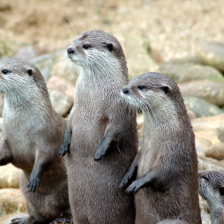

In [7]:
scorer.preprocess_image(naro_results[32])